# Ray Simulation in Penrose cavity - Juman @ QFLL (2018.12.22)
## Just Drag and drop the points in the PSOS and look what happens in the ray dynamics




## 2. Ver2019.01.03 : 기울여서 자르는 각도 설정 가능하게 변경
### cut angle을 바꿔서 자르는 각도를 변화시킬 수 있습니다.

### 동일한 focdist 값에서 cut angle은 수평에 대한 각도입니다. cut angle을 $\frac{\pi}{2}$ 로 잡으면 원래 시뮬레이션과 동일하게 됩니다.
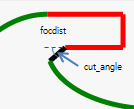
### 빨간 벽에 대해 수직으로 자를 때는 자르는 각도가 초점 근처에서 타원의 접선의 기울기와 동일하기 때문에 타원에서 별로 벗어나지 않지만 기울여서 자를 경우 조금만 잘라도 타원의 형태를 크게 변형시키기 때문에 decay time을 더 급격하게 변화시킬 것으로 예상됩니다.

### (0.47,0.93) 근처(0.01 이내)의 25개의 초기조건들에 대해 cut angle 값을 $18^{\circ},36^{\circ},54^{\circ},72^{\circ},90^{\circ}$로  바꾸면서 다른 영역으로 넘어가는 평균 reflection 수의 변화를 cut width에 따라 계산하여 그렸습니다. 
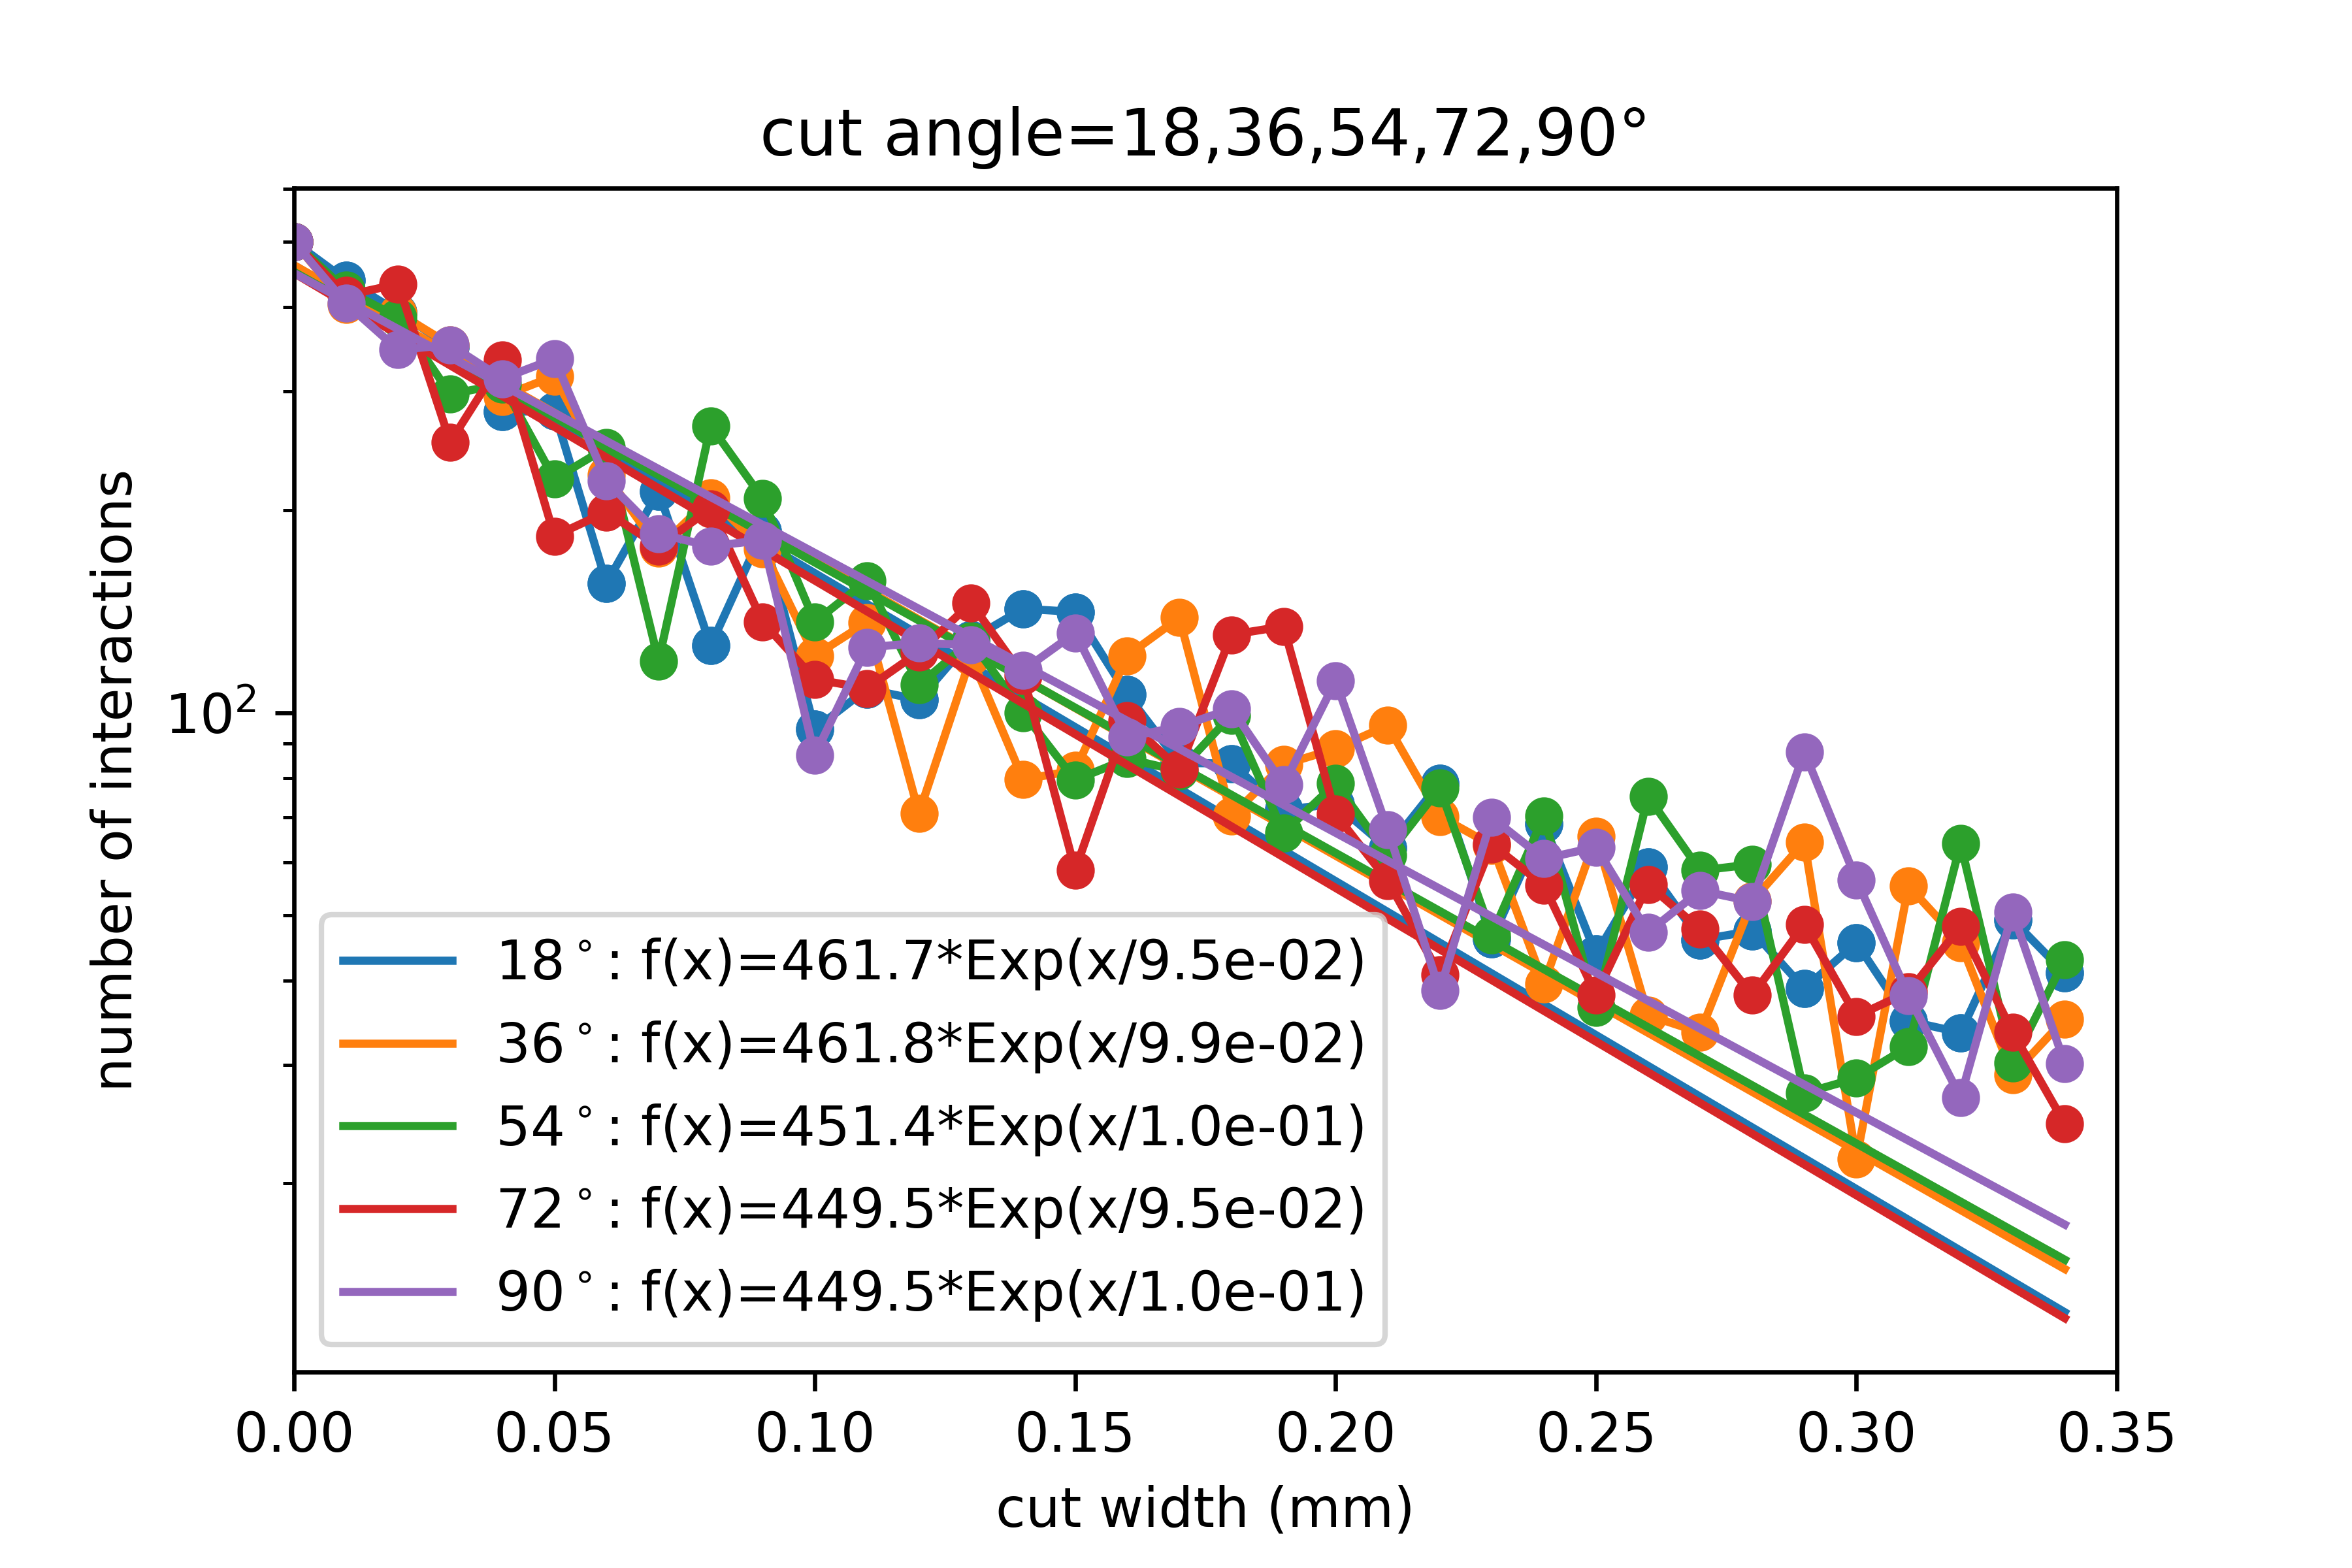

### 예상과는 다르게 cut width에 따른 behavior 가 크게 변하지 않고 exponential function으로 fitting이 잘 되지 않았습니다.

### 저의 data의 경우 exponent의 차수를 늘리기보다는 offset을 줬을 때 good fitting이 되는 것을 볼 수 있었습니다.
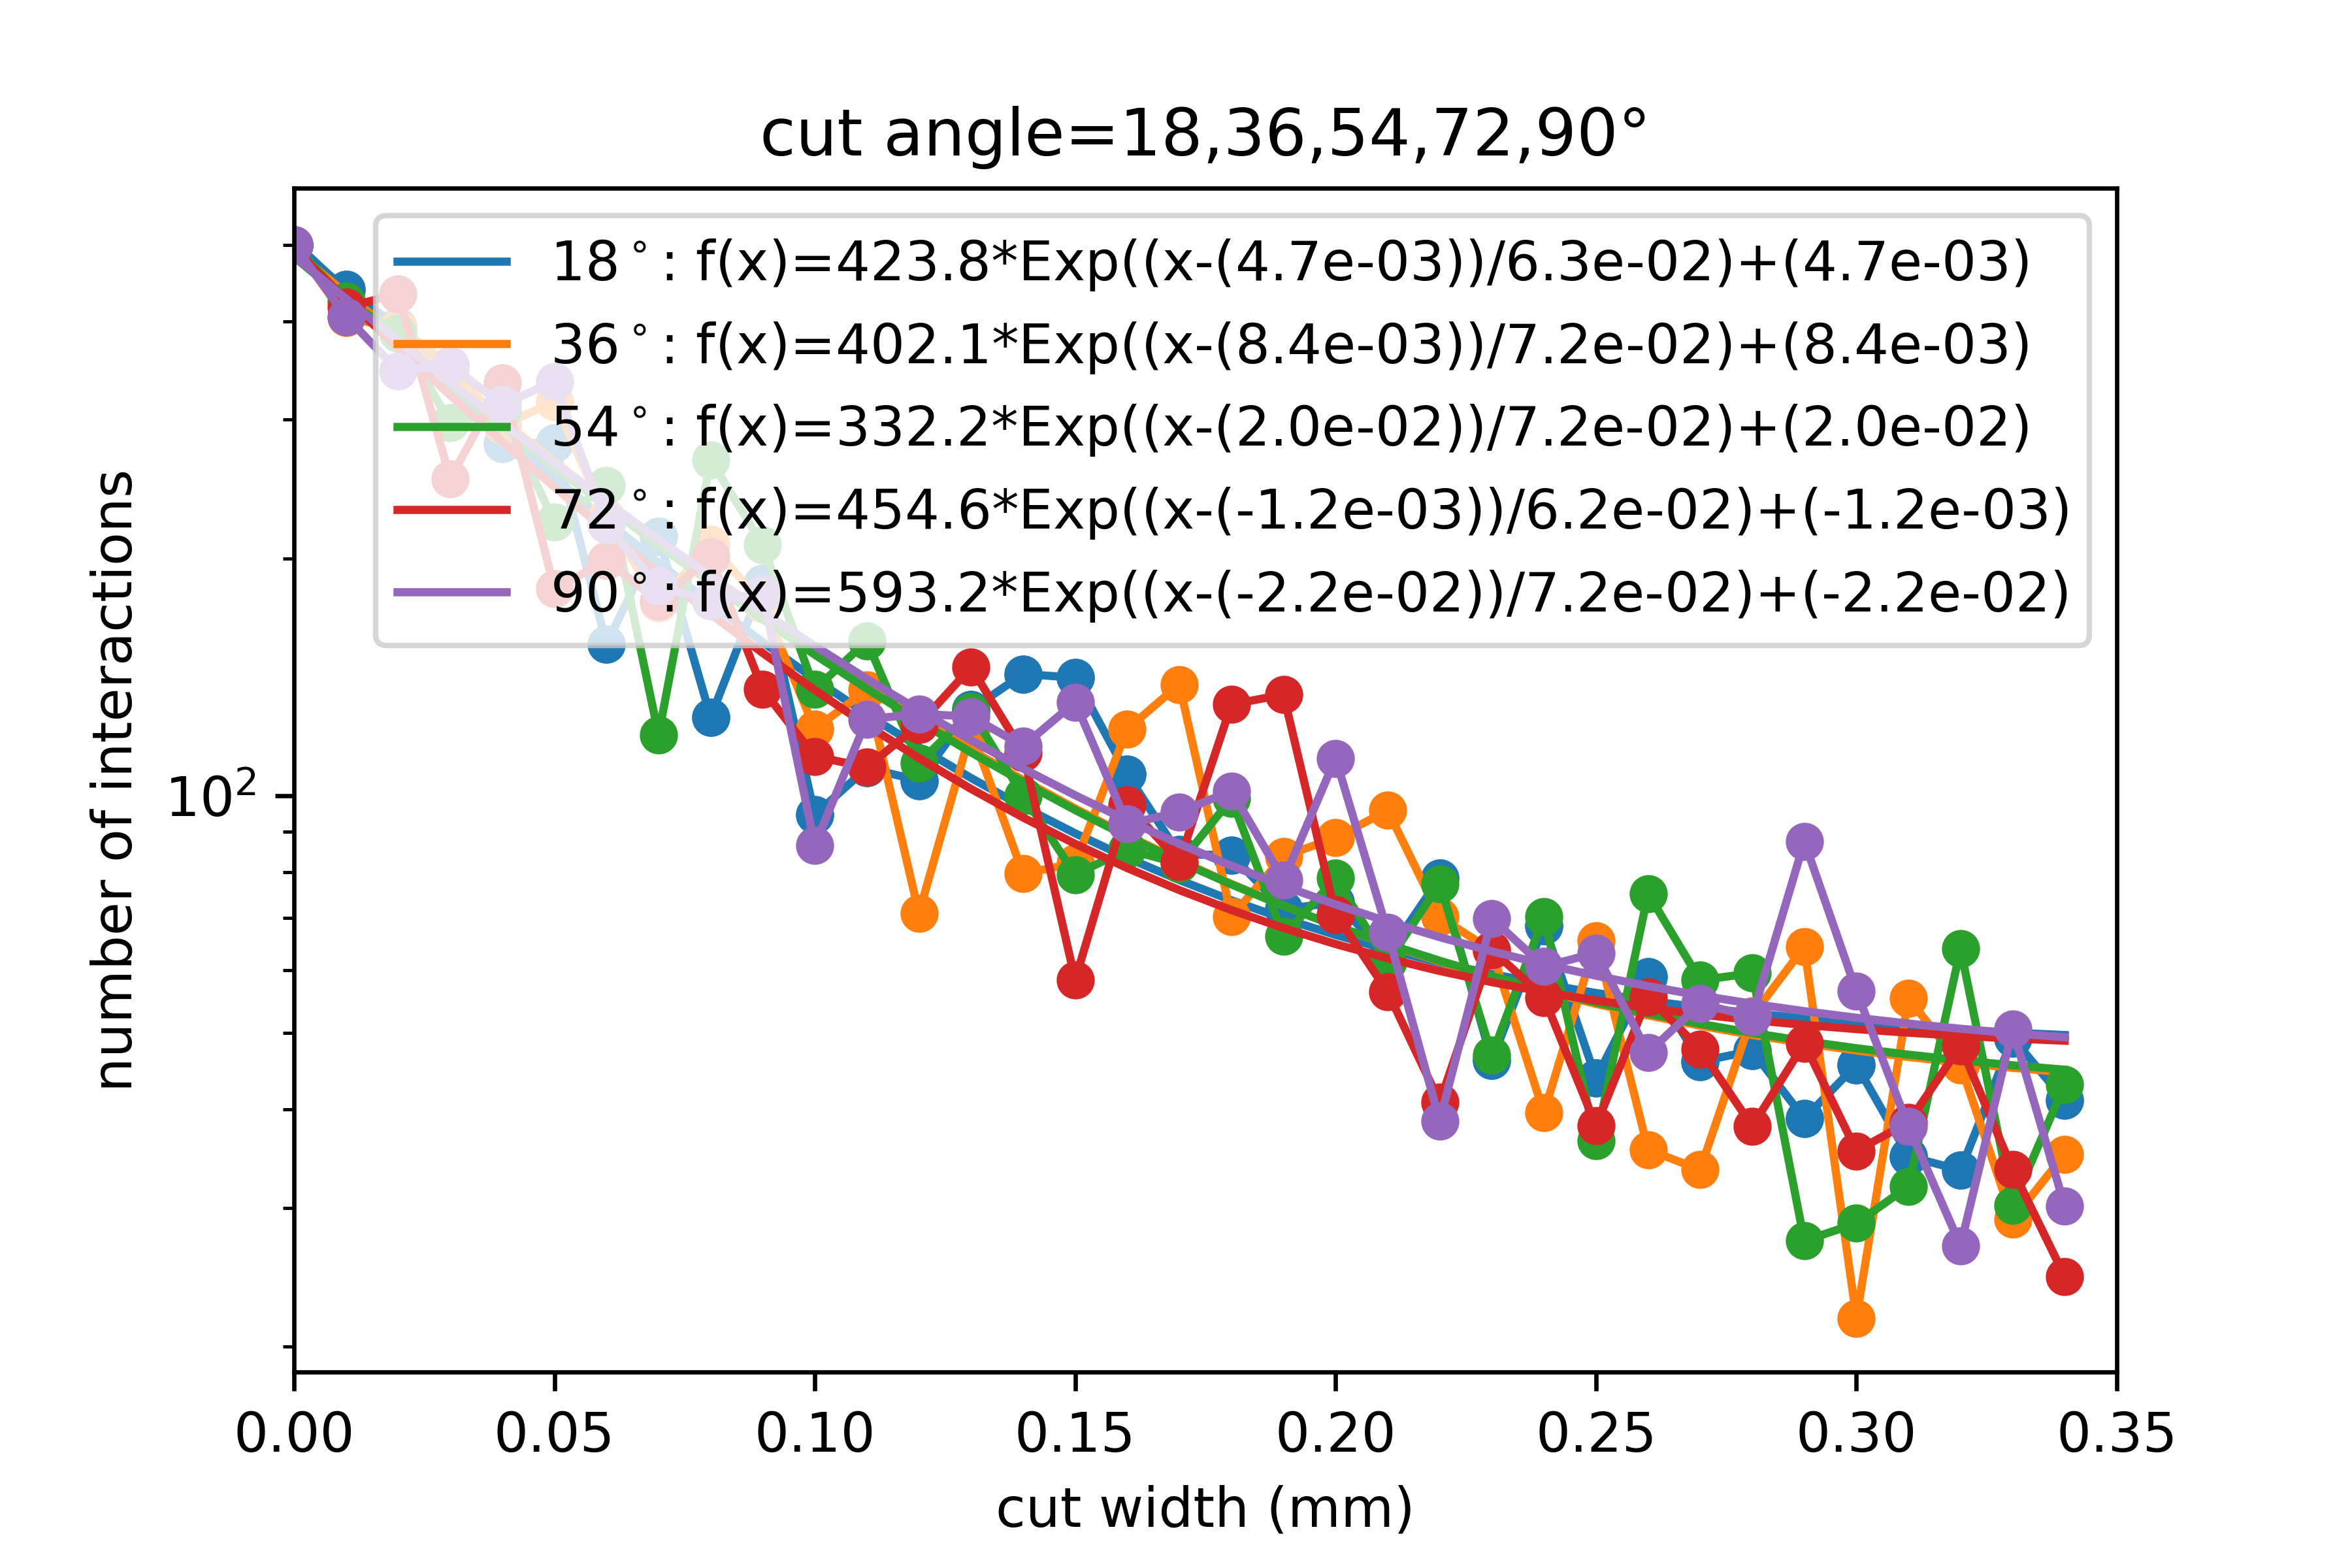

In [1]:
# -*- coding: utf-8 -*-
from __future__ import print_function
import numpy as np
from bqplot import Axis,LinearScale,Scatter,Lines,Figure,Toolbar
from bqplot import *
from ipywidgets import Label,HBox,VBox,FloatSlider,IntSlider,Play,jslink,Layout
import dynamical_barrier as db
import math
import os
from tqdm import tnrange,tqdm_notebook
import ipywidgets as widgets
from bqplot import pyplot as plt
import shutil
if not os.path.exists('Penrose_Temp'):
    os.mkdir('Penrose_Temp')
if not os.path.exists('Barrier_Temp'):
    os.mkdir('Barrier_Temp')
folder = os.getcwd()+'\\Penrose_Temp'

#https://stackoverflow.com/questions/185936/how-to-delete-the-contents-of-a-folder-in-python
for the_file in os.listdir(folder):
    file_path = os.path.join(folder, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
        #elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)
#Thanks to Bloomberg for bqplot module and guide

### Penrose cavity의 geometry에 해당하는 전역변수입니다.

In [2]:
a=3.
b=4.8
a1=3.
b1=1.945
c=0.9
k = np.sqrt(np.absolute(a**2-b**2))

In [3]:
#x_data=[0.33010]
#y_data=[0.46427]
x_data=[0.47]
y_data=[0.93]
sc_x = LinearScale(min=0.0,max=1.0)
sc_y = LinearScale(min=-1.0,max=1.0)
sc_x2=LinearScale(min=-6,max=6)
sc_y2=LinearScale(min=-4.8,max=4.8)
tt = Tooltip(fields=['x', 'y'], labels=['position', 'momentum'],formats=['.2f','.2f'])
#PSOS
scat = Scatter(x=x_data, y=y_data, scales={'x': sc_x, 'y': sc_y}, colors=['orange'],enable_move=True,tooltip=tt)
#Penrose
scat2 = Scatter(x=[], y=[], scales={'x': sc_x2, 'y': sc_y2},colors=['orange'])
init_ray=Lines(x=[],y=[],scales={'x':sc_x2,'y':sc_y2},line_style='solid',colors=['orange'],stroke_width=1)


### focdist는 초점 근처를 자른 길이, h1,h2는 PSOS 상에 정사각형 영역을 잡을 때 수평방향 길이와 수직방향 길이, q는 영역 안에 있는 initial condition들의 개수입니다. 그리고 n 은 step 수, cut_angle은 각도입니다.

In [4]:
## n_slider=IntSlider(min=100,max=200,step=10)
focdist_slider=FloatSlider(min=0.01,max=0.2,step=0.01)
focdist=0.1
h1=0.01
h2=0.01
q=5
n=100
focdist=float(input("cut width=? (mm)---->"))
cut_angle=float(input("cut angle=? (\N{DEGREE SIGN}) ---->"))*np.pi/180.
# key=input("1) instant plot, 2) cumulative plot----->  ")
# key=int(key)
key=2
progress_bar=tnrange(n+1,desc='Now loading',leave=False)

Penrose=db.geometry(a,b,a1,b1,c,focdist,cut_angle)
def plot_ellipse(a,b,xdis,ydis,iang,fang):
    q_ellipse=100
    step=(fang-iang)/q_ellipse
    x=np.ones(q_ellipse+1)
    y=np.ones(q_ellipse+1)

    for t in range(q_ellipse+1):
        theta=iang+step*t
        x[t]*=(xdis+a*np.cos(theta))
        y[t]*=(ydis+b*np.sin(theta))
    return x,y

wall_lines=[]
r_cut=(-(a1-focdist)*np.cos(cut_angle)/a1**2+np.sqrt(((a1-focdist)*np.cos(cut_angle)/a1**2)**2-((a1-focdist)**2/a1**2-1)*(np.cos(cut_angle)**2/a1**2+np.sin(cut_angle)**2/b1**2)))/(np.cos(cut_angle)**2/a1**2+np.sin(cut_angle)**2/b1**2)
ellipse_phi=math.acos((a1-focdist+r_cut*np.cos(cut_angle))/a1)


#Wall
wall_lines.append(Lines(x=[-a1,-c],y=[b,b],scales={'x':sc_x2,'y':sc_y2},line_style='solid',colors=['red'],stroke_width=5)) #1
wall_lines.append(Lines(x=[-a1+focdist,-c],y=[k,k],scales={'x':sc_x2,'y':sc_y2},line_style='solid',colors=['red'],stroke_width=5)) #2
wall_lines.append(Lines(x=[-a1+focdist,-a1+focdist-r_cut*np.cos(cut_angle)],y=[k,k-r_cut*np.sin(cut_angle)],scales={'x':sc_x2,'y':sc_y2},line_style='solid',colors=['black'],stroke_width=5)) #3
wall_lines.append(Lines(x=[a1-focdist,a1-focdist+r_cut*np.cos(cut_angle)],y=[k,k-r_cut*np.sin(cut_angle)],scales={'x':sc_x2,'y':sc_y2},line_style='solid',colors=['black'],stroke_width=5)) #4
wall_lines.append(Lines(x=[-a1+focdist,-a1+focdist-r_cut*np.cos(cut_angle)],y=[-k,-k+r_cut*np.sin(cut_angle)],scales={'x':sc_x2,'y':sc_y2},line_style='solid',colors=['black'],stroke_width=5)) #5
wall_lines.append(Lines(x=[a1-focdist,a1-focdist+r_cut*np.cos(cut_angle)],y=[-k,-k+r_cut*np.sin(cut_angle)],scales={'x':sc_x2,'y':sc_y2},line_style='solid',colors=['black'],stroke_width=5)) #6
wall_lines.append(Lines(x=[c,a1],y=[b,b],scales={'x':sc_x2,'y':sc_y2},line_style='solid',colors=['blue'],stroke_width=5)) #7
wall_lines.append(Lines(x=[c,a1-focdist],y=[k,k],scales={'x':sc_x2,'y':sc_y2},line_style='solid',colors=['blue'],stroke_width=5)) #8
wall_lines.append(Lines(x=[-a1+focdist,-c],y=[-k,-k],scales={'x':sc_x2,'y':sc_y2},line_style='solid',colors=['red'],stroke_width=5)) #9
wall_lines.append(Lines(x=[-a1,-c],y=[-b,-b],scales={'x':sc_x2,'y':sc_y2},line_style='solid',colors=['red'],stroke_width=5)) #10
wall_lines.append(Lines(x=[c,a1-focdist],y=[-k,-k],scales={'x':sc_x2,'y':sc_y2},line_style='solid',colors=['blue'],stroke_width=5)) #11
wall_lines.append(Lines(x=[c,a1],y=[-b,-b],scales={'x':sc_x2,'y':sc_y2},line_style='solid',colors=['blue'],stroke_width=5)) #12
wall_lines.append(Lines(x=[-c,-c],y=[k,b],scales={'x':sc_x2,'y':sc_y2},line_style='solid',colors=['red'],stroke_width=5)) #13
wall_lines.append(Lines(x=[-c,-c],y=[-k,-b],scales={'x':sc_x2,'y':sc_y2},line_style='solid',colors=['red'],stroke_width=5)) #14
wall_lines.append(Lines(x=[c,c],y=[k,b],scales={'x':sc_x2,'y':sc_y2},line_style='solid',colors=['blue'],stroke_width=5)) #15
wall_lines.append(Lines(x=[c,c],y=[-k,-b],scales={'x':sc_x2,'y':sc_y2},line_style='solid',colors=['blue'],stroke_width=5)) #16
wall_lines.append(Lines(x=plot_ellipse(a,b,-a1,0,np.pi/2,3*np.pi/2)[0],y=plot_ellipse(a,b,-a1,0,np.pi/2,3*np.pi/2)[1],scales={'x':sc_x2,'y':sc_y2},line_style='solid',colors=['green'],stroke_width=5)) #17
wall_lines.append(Lines(x=plot_ellipse(a,b,a1,0,-np.pi/2,np.pi/2)[0],y=plot_ellipse(a,b,a1,0,-np.pi/2,np.pi/2)[1],scales={'x':sc_x2,'y':sc_y2},line_style='solid',colors=['green'],stroke_width=5)) #18
wall_lines.append(Lines(x=plot_ellipse(a1,b1,0,-k,ellipse_phi,np.pi-ellipse_phi)[0],y=plot_ellipse(a1,b1,0,-k,ellipse_phi,np.pi-ellipse_phi)[1],scales={'x':sc_x2,'y':sc_y2},line_style='solid',colors=['green'],stroke_width=5)) #19
wall_lines.append(Lines(x=plot_ellipse(a1,b1,0,k,np.pi+ellipse_phi,2*np.pi-ellipse_phi)[0],y=plot_ellipse(a1,b1,0,k,np.pi+ellipse_phi,2*np.pi-ellipse_phi)[1],scales={'x':sc_x2,'y':sc_y2},line_style='solid',colors=['green'],stroke_width=5)) #20



def color(DB):
    if DB==1:
        return 'red'
    if DB==2:
        return 'blue'
    if DB==3:
        return 'green'
    if DB==4:
        return 'black'

rays=Lines(x=[],y=[],scales={'x':sc_x2,'y':sc_y2},line_style='solid',colors=['orange'],stroke_width=1)
PSOS_points=Scatter(x=[], y=[], scales={'x': sc_x, 'y': sc_y}, colors=['orange'],default_size=10)
previous_rays=Lines(x=[],y=[],scales={'x':sc_x2,'y':sc_y2},line_style='solid',colors=['orange'],stroke_width=1)
previous_PSOS_points=Scatter(x=[], y=[], scales={'x': sc_x, 'y': sc_y}, colors=['orange'],default_size=10)
point_report = Scatter(x=[], y=[], scales={'x': sc_x, 'y': sc_y},colors=['orange'],default_size=10)
chosen_report = Scatter(x=[], y=[], scales={'x': sc_x, 'y': sc_y},colors=['cyan'],tooltip=tt,enable_hover=True,stroke='magenta')
ray_report=Lines(x=[],y=[],scales={'x':sc_x2,'y':sc_y2},line_style='solid',colors=['orange'],stroke_width=1)

ax_x = Axis(scale=sc_x, tick_format='0.1f', orientation='horizontal')
ax_y = Axis(scale=sc_y, tick_format='0.1f', orientation='vertical')
ax_x2=Axis(scale=sc_x2, orientation='horizontal',visible=False)
ax_y2=Axis(scale=sc_y2, orientation='vertical',visible=False)
ax_x.label='position'
ax_y.label='momentum'

fig = Figure(marks=[previous_PSOS_points,PSOS_points,scat], axes=[ax_x, ax_y],fig_margin={'top':110,'bottom':40,'left':40,'right':60},title='PSOS',max_aspect_ratio=12/9.6)
fig2=Figure(marks=[scat2,init_ray,previous_rays,rays]+wall_lines,axes=[ax_x2,ax_y2],fig_margin={'top':110,'bottom':40,'left':10,'right':30},title='Ray_simulation',max_aspect_ratio=12/9.6)
fig_report=Figure(marks=[point_report,chosen_report],axes=[ax_x,ax_y],fig_margin={'top':110,'bottom':40,'left':40,'right':60},title='PSOS_Report')
fig2_report=Figure(marks=[ray_report]+wall_lines,axes=[ax_x2,ax_y2],fig_margin={'top':110,'bottom':40,'left':10,'right':30},title='Ray_Report',max_aspect_ratio=12/9.6)

def update_point(change=None):
    with scat2.hold_sync():
        irayset=np.array(Penrose.IC_generator(scat.x[0],scat.y[0],h1,h2,q,q))
        scat2.x=irayset.T[0]
        scat2.y=irayset.T[1]
        xset=[]
        yset=[]
        for i in range(q*q):
            fray=Penrose.reflected_ray(irayset[i])
            xset.append([irayset[i][0],fray[0]])
            yset.append([irayset[i][1],fray[1]])
        init_ray.x=xset
        init_ray.y=yset

irayset=np.array(Penrose.IC_generator(scat.x[0],scat.y[0],h1,h2,q,q))
xrayset=[]
yrayset=[]
xtemp=[]
ytemp=[]
xPSOSset=[]
yPSOSset=[]
PSOS_colors=[]
filename=os.getcwd()+'\\Penrose_Temp\\Dx=%.5f,yx=%.5f,trial=0.txt' % (scat.x[0],scat.y[0])
filename2=os.getcwd()+'\\Penrose_Temp\\Dx=%.5f,yx=%.5f,pointstemp0.txt' % (scat.x[0],scat.y[0])
filename3=os.getcwd()+'\\Penrose_Temp\\chosenset.txt'
filename4=os.getcwd()+'\\Penrose_Temp\\Dx=%.5f,yx=%.5f.txt'% (scat.x[0],scat.y[0]) 
next_number_file=open(os.getcwd()+'\\Penrose_Temp\\next_number.txt','w')
next_number_file.write('%d' % 0)
next_number_file.close()
with open(filename, "w") as fp, open(filename2, "w") as fp2, open(filename3,'a') as fp3, open(filename4,'a') as fp4:
    #file information
    fp3.write('%.5f %.5f\n' % (x_data[0],y_data[0]))
    #fp.write('%d %f %f %f %f %f %d\n' % (n,scat.x[0],scat.y[0],focdist,h1,h2,q))
    for t in progress_bar:
        for i in range(q*q):
            fray=Penrose.reflected_ray(irayset[i])
            ang_diff=Penrose.nangle_pt(fray[0],fray[1],fray[3])-fray[2]
            DB=Penrose.Dynamical_Barrier(fray[0],fray[1],ang_diff,fray[3])
            data=[Penrose.eta(fray[0],fray[1],fray[3])/Penrose.eta(0,0,14),np.sin(ang_diff)]
            xrayset.append([irayset[i][0],fray[0]])
            yrayset.append([irayset[i][1],fray[1]])
            xPSOSset.append(data[0])
            yPSOSset.append(data[1])
            PSOS_colors.append(color(DB))
            #data
            fp.write('%f %f %f %f %f %f %d\n' % (irayset[i][0],irayset[i][1],fray[0],fray[1],data[0],data[1],DB))
            fp4.write('%f %f %f %f %f %f %d\n' % (irayset[i][0],irayset[i][1],fray[0],fray[1],data[0],data[1],DB))
            if t==n:
                fp2.write('%.12f %.12f %.12f %.12f\n' % (fray[0],fray[1],fray[2],fray[3]))    
            for m in range(4):
                irayset[i][m]=fray[m]

    #def update_focdist(change=None):
    scat.update_on_move=True    
    rays.x=xrayset
    rays.y=yrayset
    rays.curves_subset=[q*q*(n+2)]
    PSOS_points.x=xPSOSset
    PSOS_points.y=yPSOSset
    PSOS_points.colors=PSOS_colors
    PSOS_points.default_opacities=[0]*(q*q)+[0]*(q*q*(n))
    rays.x=xrayset
    rays.y=yrayset
    rays.curves_subset=[q*q*(n+1)]
    PSOS_points.x=xPSOSset
    PSOS_points.y=yPSOSset
    PSOS_points.colors=PSOS_colors
    PSOS_points.default_opacities=[0]*(q*q)+[0]*(q*q*(n))
    #PSOS_points.curves_subset=[0]

def start_func(self,content):
    previous_rays.curves_subset=[-1]
    previous_PSOS_points.default_opacities=[0]
    rays.curves_subset=[-1]
    PSOS_points.default_opacities=[0]
def end_func(self,content):
    init_ray.curves_subset=[]
    next_number_file=open(os.getcwd()+'\\Penrose_Temp\\next_number.txt','w')
    next_number_file.write('%d' % 0)
    next_number_file.close()
    progress_bar=tnrange(n+1,desc='Now loading',leave=False)
    irayset=np.array(Penrose.IC_generator(scat.x[0],scat.y[0],h1,h2,q,q))
    xrayset=[]
    yrayset=[]
    xtemp=[]
    ytemp=[]
    xPSOSset=[]
    yPSOSset=[]
    PSOS_colors=[]
    filename=os.getcwd()+'\\Penrose_Temp\\Dx=%.5f,yx=%.5f,trial=0.txt'% (scat.x[0],scat.y[0]) 
    filename2=os.getcwd()+'\\Penrose_Temp\\Dx=%.5f,yx=%.5f,pointstemp0.txt'%(scat.x[0],scat.y[0])
    filename3=os.getcwd()+'\\Penrose_Temp\\chosenset.txt'
    filename4=os.getcwd()+'\\Penrose_Temp\\Dx=%.5f,yx=%.5f.txt'% (scat.x[0],scat.y[0]) 
    with open(filename, "w") as fp, open(filename2, "w") as fp2, open(filename3,'a') as fp3, open(filename4,'a') as fp4:
        #file information
        fp3.write('%.5f %.5f\n' % (scat.x[0],scat.y[0]))
        #fp.write('%d %f %f %f %f %f %d\n' % (n,scat.x[0],scat.y[0],focdist,h1,h2,q))
        for t in progress_bar:
            for i in range(q*q):
                fray=Penrose.reflected_ray(irayset[i])
                ang_diff=Penrose.nangle_pt(fray[0],fray[1],fray[3])-fray[2]
                DB=Penrose.Dynamical_Barrier(fray[0],fray[1],ang_diff,fray[3])
                data=[Penrose.eta(fray[0],fray[1],fray[3])/Penrose.eta(0,0,14),np.sin(ang_diff)]
                xrayset.append([irayset[i][0],fray[0]])
                yrayset.append([irayset[i][1],fray[1]])
                xPSOSset.append(data[0])
                yPSOSset.append(data[1])
                PSOS_colors.append(color(DB))
                #data
                fp.write('%f %f %f %f %f %f %d\n' % (irayset[i][0],irayset[i][1],fray[0],fray[1],data[0],data[1],DB))
                fp4.write('%f %f %f %f %f %f %d\n' % (irayset[i][0],irayset[i][1],fray[0],fray[1],data[0],data[1],DB))
                if t==n:
                    fp2.write('%.12f %.12f %.12f %.12f\n' % (fray[0],fray[1],fray[2],fray[3]))
                for m in range(4):
                    irayset[i][m]=fray[m]
        rays.x=xrayset
        rays.y=yrayset
        rays.curves_subset=[q*q*(n+1)]
        PSOS_points.x=xPSOSset
        PSOS_points.y=yPSOSset
        PSOS_points.colors=PSOS_colors
        PSOS_points.default_opacities=[0]*(q*q)+[0]*(q*q*(n))
scat.on_drag_start(start_func)
scat.on_drag_end(end_func)

update_point() 

next_button=widgets.Button(description="Next 100 step")
def next_button_clicked(b):
    temp_list=open(os.getcwd()+'\\Penrose_Temp\\next_number.txt').read()
    temp_list=list(map(int,temp_list))
    next_number=temp_list[0]
    next_number=next_number+1
    next_number_file=open(os.getcwd()+'\\Penrose_Temp\\next_number.txt','w')
    next_number_file.write('%d' % next_number)
    progress_bar=tnrange(n+1,desc='Now loading',leave=False)
    #irayset=np.array(Penrose.IC_generator(scat.x[0],scat.y[0],focdist,h1,h2,q,q,cut_angle))    
    trial=0
    while os.path.exists(os.getcwd()+'\\Penrose_Temp\\Dx=%.5f,yx=%.5f,pointstemp%d.txt' % (scat.x[0],scat.y[0],trial)):
        trial=trial+1
        filename3=os.getcwd()+'\\Penrose_Temp\\Dx=%.5f,yx=%.5f,trial=%d.txt' % (scat.x[0],scat.y[0],trial)
        filename4=os.getcwd()+'\\Penrose_Temp\\Dx=%.5f,yx=%.5f,pointstemp%d.txt' % (scat.x[0],scat.y[0],trial)
    filename=os.getcwd()+'\\Penrose_Temp\\Dx=%.5f,yx=%.5f,trial=%d.txt' % (scat.x[0],scat.y[0],trial-1)
    filename2=os.getcwd()+'\\Penrose_Temp\\Dx=%.5f,yx=%.5f,pointstemp%d.txt' % (scat.x[0],scat.y[0],trial-1)
    filename5=os.getcwd()+'\\Penrose_Temp\\Dx=%.5f,yx=%.5f.txt'% (scat.x[0],scat.y[0]) 
    previous_points=open(filename5).read().split()
    previous_points=list(map(float,previous_points))
    previous_xrayset=[(previous_points[i],previous_points[i+2]) for i in range(0,len(previous_points),7)]
    previous_yrayset=[(previous_points[i],previous_points[i+2]) for i in range(1,len(previous_points),7)]
    previous_xPSOSset=[previous_points[i] for i in range(4,len(previous_points),7)]
    previous_yPSOSset=[previous_points[i] for i in range(5,len(previous_points),7)]
    previous_colorset=[color(previous_points[i])for i in range(6,len(previous_points),7)]
    previous_rays.x=previous_xrayset
    previous_rays.y=previous_yrayset
    previous_PSOS_points.x=previous_xPSOSset
    previous_PSOS_points.y=previous_yPSOSset
    previous_PSOS_points.colors=previous_colorset
    previous_rays.curves_subset=[]
    previous_PSOS_points.default_opacities=[1]
    if key==1:
        previous_rays.curves_subset=[-1]
        previous_PSOS_points.default_opacities=[0]
    pointstemp=open(filename2).read().split()
    pointstemp=list(map(float,pointstemp))
    irayset=[[pointstemp[i+4*j] for i in range(4)] for j in range(q*q)]
    xrayset=[]
    yrayset=[]
    xtemp=[]
    ytemp=[]
    xPSOSset=[]
    yPSOSset=[]
    PSOS_colors=[]
    with open(filename3, "w") as fp, open(filename4, "w") as fp2, open(filename5, 'a') as fp3:
        #file information
        #fp.write('%d %f %f %f %f %f %d\n' % (n,scat.x[0],scat.y[0],focdist,h1,h2,q))
        for t in progress_bar:
            for i in range(q*q):
                fray=Penrose.reflected_ray(irayset[i])
                ang_diff=Penrose.nangle_pt(fray[0],fray[1],fray[3])-fray[2]
                DB=Penrose.Dynamical_Barrier(fray[0],fray[1],ang_diff,fray[3])
                data=[Penrose.eta(fray[0],fray[1],fray[3])/Penrose.eta(0,0,14),np.sin(ang_diff)]
                xrayset.append([irayset[i][0],fray[0]])
                yrayset.append([irayset[i][1],fray[1]])
                xPSOSset.append(data[0])
                yPSOSset.append(data[1])
                PSOS_colors.append(color(DB))
                #data
                fp.write('%f %f %f %f %f %f %d\n' % (irayset[i][0],irayset[i][1],fray[0],fray[1],data[0],data[1],DB))
                fp3.write('%f %f %f %f %f %f %d\n' % (irayset[i][0],irayset[i][1],fray[0],fray[1],data[0],data[1],DB))
                if t==n:
                    fp2.write('%.12f %.12f %.12f %.12f\n' % (fray[0],fray[1],fray[2],fray[3]))
                for m in range(4):
                    irayset[i][m]=fray[m]
        rays.x=xrayset
        rays.y=yrayset
        rays.curves_subset=[q*q*(n+1)]
        PSOS_points.x=xPSOSset
        PSOS_points.y=yPSOSset
        PSOS_points.colors=PSOS_colors
        PSOS_points.default_opacities=[0]*(q*q)+[0]*(q*q*(n))
#         fig.save_png(os.getcwd()+'\\Penrose_Temp\\Rayimage_Dx=%.5f,yx=%.5f.png' % (scat.x[0],scat.y[0]))
#         fig2.save_png(os.getcwd()+'\\Penrose_Temp\\PSOS_Dx=%.5f,yx=%.5f.png' % (scat.x[0],scat.y[0]))
next_button.on_click(next_button_clicked)

step_slider=IntSlider(min=0,max=n,step=1,description='Step',value=0)
plot_style=widgets.Dropdown(
    options=['instant plot', 'cumulative plot'],
    value='cumulative plot',
    description='Plot style:',
    disabled=False,
)
def ray_simulation(change):
    temp=[]
    temp2=[0]*(q*q*(n+1))
    next_number=0
    temp_list=open(os.getcwd()+'\\Penrose_Temp\\next_number.txt').read()
    temp_list=list(map(int,temp_list))
    next_number=temp_list[0]
    with step_slider.hold_sync():
        k=step_slider.value
        if k==0:
            init_ray.curves_subset=[]
            rays.curves_subset=[q*q*(n+1)]
            PSOS_points.default_opacities=temp2
            fig.title='PSOS (step: '+str(k+next_number*100)+')'
            fig2.title='Ray_simulation (step: '+str(k+next_number*100)+')'
        else:
            if key==1:
                init_ray.curves_subset=[]
                rays.curves_subset=[i+q*q*k for i in range(q*q)]
                for i in range(q*q*(n+1)):
                    if i<(k+1)*q*q and k*q*q<=i:
                        temp2[i]=1
                PSOS_points.default_opacities=temp2
                fig.title='PSOS (step: '+str(k+next_number*100)+')'
                fig2.title='Ray_simulation (step: '+str(k+next_number*100)+')'
            else:
                init_ray.curves_subset=[]
                for t in range(k+1):
                    temp=temp+[i+q*q*t for i in range(q*q)]
                rays.curves_subset=temp
                for i in range(q*q*(n+1)):
                    if i<(k+1)*q*q:
                        temp2[i]=1
                PSOS_points.default_opacities=temp2
                fig.title='PSOS (step: '+str(k+next_number*100)+')'
                fig2.title='Ray_simulation (step: '+str(k+next_number*100)+')'
#             if k==100:
#                 fig.save_png(os.getcwd()+'\\Penrose_Temp\\Rayimage_Dx=%.5f,yx=%.5f.png' % (scat.x[0],scat.y[0]))
#                 fig2.save_png(os.getcwd()+'\\Penrose_Temp\\PSOS_Dx=%.5f,yx=%.5f.png' % (scat.x[0],scat.y[0]))
                          
step_slider.observe(ray_simulation,'value')

# animation speed: change the interval
play_button = Play(min=0, max=n,interval=100)
jslink((play_button,'value'),(step_slider,'value'))

# update line on change of x or y of scatter
scat.observe(update_point, names=['x'])
scat.observe(update_point, names=['y'])

Save_button=widgets.Button(description='save current images',icon='save',layout=Layout(width='20%'),button_style='success')
def save_state(b):
    fig.save_png('PSOS_Dx=%.5f,yx=%.5f.png' % (scat.x[0],scat.y[0]))
    fig2.save_png('ray_Dx=%.5f,yx=%.5f.png' % (scat.x[0],scat.y[0]))
Save_button.on_click(save_state)

Save_report_button=widgets.Button(description='save report',icon='save',layout=Layout(width='20%'),button_style='success')
def save_report(b):
    fig_report.save_png('PSOS_report.png')
    fig2_report.save_png('ray_report.png')
Save_report_button.on_click(save_report)
Report_button=widgets.Button(description='Report',button_style='info')
Show_every_points=widgets.Button(description='Show every points(caution: very slow)',layout=Layout(width='25%'),button_style='warning')
def Report(b):
    filename=os.getcwd()+'\\Penrose_Temp\\chosenset.txt'
    chosenlist=open(filename).read().split()
    chosenlist=list(map(float,chosenlist))
    xchosen=[chosenlist[i] for i in range(0,len(chosenlist),2)]
    ychosen=[chosenlist[i] for i in range(1,len(chosenlist),2)]
    chosen_report.x=xchosen
    chosen_report.y=ychosen
def Show_entire(b):
    ray_report.visible = True
    point_report.visible=True
    filename=os.getcwd()+'\\Penrose_Temp\\chosenset.txt'
    chosenlist=open(filename).read().split()
    chosenlist=list(map(float,chosenlist))
    xchosen=[chosenlist[i] for i in range(0,len(chosenlist),2)]
    ychosen=[chosenlist[i] for i in range(1,len(chosenlist),2)]
    filelist=[]
    xPSOSset=[]
    yPSOSset=[]
    PSOS_colors=[]
    for i in range(0,len(xchosen)):
        file=open(os.getcwd()+'\\Penrose_Temp\\Dx=%.5f,yx=%.5f.txt'% (xchosen[i],ychosen[i])).read().split()
        file=list(map(float,file))
        xPSOSset=xPSOSset+[file[i] for i in range(4,len(file),7)]
        yPSOSset=yPSOSset+[file[i] for i in range(5,len(file),7)]
        PSOS_colors=PSOS_colors+[color(file[i]) for i in range(6,len(file),7)]
    point_report.x=xPSOSset
    point_report.y=yPSOSset
    point_report.colors=PSOS_colors
    point_report.default_opacities=[1]
    point_report.default_size=10
Report_button.on_click(Report)
Show_every_points.on_click(Show_entire)


def Choose_display(change):
    if change.new is not None:
        filelist=[]
        xrayset=[]
        yrayset=[]
        xpointset=[]
        ypointset=[]
        colorset=[]
        for item in change.new:
            file=open(os.getcwd()+'\\Penrose_Temp\\Dx=%.5f,yx=%.5f.txt' %(chosen_report.x[item],chosen_report.y[item])).read().split()
            temp_list=list(map(float,file))
            xrayset=xrayset+[(temp_list[i],temp_list[i+2]) for i in range(0,len(temp_list),7)]
            yrayset=yrayset+[(temp_list[i],temp_list[i+2]) for i in range(1,len(temp_list),7)]
            xpointset=xpointset+[temp_list[i] for i in range(4,len(temp_list),7)]
            ypointset=ypointset+[temp_list[i] for i in range(5,len(temp_list),7)]
            colorset=colorset+[color(temp_list[i]) for i in range(6,len(temp_list),7)]
        ray_report.x=xrayset
        ray_report.y=yrayset
        point_report.x=xpointset
        point_report.y=ypointset
        point_report.colors=colorset
        ray_report.visible = True
        point_report.visible=True
    else:
        ray_report.visible = False
        point_report.visible=False
#chosen_report.enable_hover=False
chosen_report.interactions={'click':'select'}
chosen_report.selected_style={'opacity': 1.0, 'fill': 'DarkOrange', 'stroke': 'cyan'}
chosen_report.unselected_style={'opacity': 1.0}
#chosen_report.on_element_click(Choose_display, 'selected')
chosen_report.observe(Choose_display, 'selected')


VBox([HBox([play_button,step_slider,next_button]),HBox([fig2,fig]),HBox([Save_button])])

cut width=? (mm)---->0.5
cut angle=? (°) ---->45


In [5]:
VBox([HBox([Show_every_points,Report_button]),HBox([fig2_report,fig_report]),HBox([Save_report_button])])

# 2018.12.29 추가 주의사항
### 1. 주의!) Restart&Run All 을 누르면 현재까지 계산된 결과들이 다 날아갑니다. 이미지 저장 혹은 Penrose_Temp 폴더를 백업해야 합니다.
### 2. PSOS 상에서 orange point에 마우스를 올려놓으면 tooltip이 뜹니다. tooltip이 뜨지 않았을 때 움직이면 잘 작동하지 않을 수 있습니다.
### 3. Report 버튼을 누르면 PSOS_Report 에 cyan point 가 생깁니다. cyan point의 의미는 이전에 계산했던 PSOS 상의 point들입니다.
### 4. 각각의 step에서의 plot은 미리 100개를 계산한 다음에 투명도만 바꾸는 것에 불과하기 때문에 100개를 재생하는 것을 기다릴 필요 없습니다.
### 5. cyan point 를 클릭하면 그 initial condition에서의 최종 결과가 뜹니다. ctrl 을 누른 채로 클릭하면 여러 점을 선택할 수 있고 이 경우 여러 점에 대한 최종 결과를 합쳐서 나타냅니다.
### 6. Show every points 를 누르면 축적된 모든 PSOS 상의 포인트들을 나타냅니다. 계산한 양이 많다면 매우 느리고 메모리 부족이 발생할 수 있습니다.
### 7. save current images 는 현재 step 에서의 Ray_simulation과 PSOS 의 screenshot을 저장합니다. (사이트 내 자동 다운로드 허용 체크)